# Yewno Assignment

## Question 1

### Google Trend explain unemployment rate

### 1) Google Trend data pull

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
from pytrends.request import TrendReq
pytrend = TrendReq(hl='en-US', tz=360) # Set USA and Timezone

In [5]:
## keyword list
kw_list = ['unemployment']
## date range
timeframe = '2004-11-01 2018-10-31'

In [6]:
## pull out keyword trend given date range
pytrend.build_payload(kw_list=kw_list, timeframe = timeframe)
interest_over_time_df = pytrend.interest_over_time().drop(['isPartial'], axis=1)

In [7]:
interest_over_time_df.head()

,unemployment
date,
2004-11-01,28
2004-12-01,25
2005-01-01,31
2005-02-01,28
2005-03-01,27


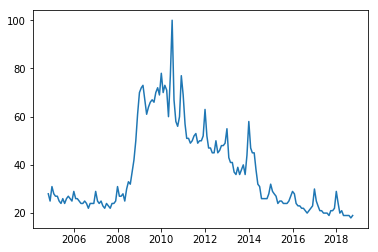

In [8]:
plt.plot(interest_over_time_df['unemployment'])
plt.show()

In [9]:
## find related words/phrase with 'unemployment'
related_queries_dict = pytrend.related_queries()
kw_related_list = related_queries_dict['unemployment']['top']['query'][0:15]

In [10]:
kw_related_list

0           unemployment rate
1       unemployment benefits
2         unemployment office
3             unemployment pa
4          unemployment claim
5           ohio unemployment
6             ny unemployment
7        florida unemployment
8            nys unemployment
9      unemployment insurance
10     unemployment extension
11         texas unemployment
12        unemployment number
13            unemployment nj
14    california unemployment
Name: query, dtype: object

In [12]:
## pull out all the trends in the list above
related_interest_over_time_df = pd.DataFrame()
for kw in kw_related_list: 
    pytrend.build_payload(kw_list=[kw], timeframe = timeframe)
    related_interest_over_time_df[kw] = pytrend.interest_over_time()[kw]
trend_df = interest_over_time_df.merge(related_interest_over_time_df, left_index=True, right_index=True, how='inner')

In [14]:
print(trend_df.shape)
print(trend_df.head())

(168, 16)
            unemployment  unemployment rate  unemployment benefits  \
date                                                                 
2004-11-01            28                 61                     14   
2004-12-01            25                 41                     15   
2005-01-01            31                 39                     16   
2005-02-01            28                 51                     15   
2005-03-01            27                 46                     13   

            unemployment office  unemployment pa  unemployment claim  \
date                                                                   
2004-11-01                   36               20                   7   
2004-12-01                   37               15                  12   
2005-01-01                   52               25                  11   
2005-02-01                   43               19                  11   
2005-03-01                   39               18                   

## 2) unemployment rate data pull (from FRED https://fred.stlouisfed.org/series/UNRATE)

In [44]:
## load data and select data from dates above
unemploy_rate = pd.read_csv('unemployment_rate.csv')
unemploy_rate['date'] = pd.to_datetime(unemploy_rate['date'])
unemploy_rate = unemploy_rate.set_index('date')
unemploy_rate_select = unemploy_rate.loc[unemploy_rate.index.isin(trend_df.index)]

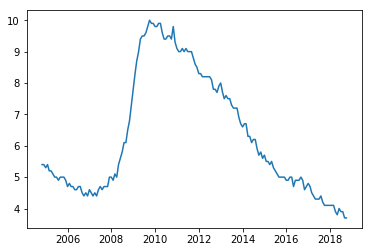

In [47]:
plt.plot(unemploy_rate_select['rate'])
plt.show()

In [48]:
print(unemploy_rate_select.shape)
print(unemploy_rate_select.head())

(168, 1)
            rate
date            
2004-11-01   5.4
2004-12-01   5.4
2005-01-01   5.3
2005-02-01   5.4
2005-03-01   5.2


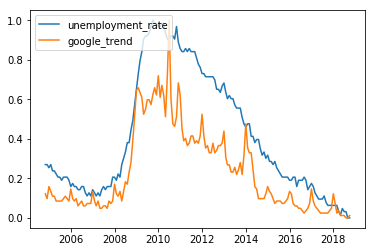

In [50]:
plt.plot((unemploy_rate_select['rate']-unemploy_rate_select['rate'].min())/(unemploy_rate_select['rate'].max()-unemploy_rate_select['rate'].min()), label='unemployment_rate')# normalize
plt.plot((interest_over_time_df['unemployment']-interest_over_time_df['unemployment'].min())/(interest_over_time_df['unemployment'].max()-interest_over_time_df['unemployment'].min()), label='google_trend')
plt.legend(loc='upper left')
plt.show()

In [51]:
trend_df_select = trend_df.loc[trend_df.index.isin(unemploy_rate_select.index)]

In [52]:
print(trend_df_select.shape)
print(trend_df_select.head())

(168, 16)
            unemployment  unemployment rate  unemployment benefits  \
date                                                                 
2004-11-01            28                 59                     15   
2004-12-01            26                 42                     13   
2005-01-01            31                 37                     17   
2005-02-01            29                 49                     16   
2005-03-01            27                 47                     14   

            unemployment office  unemployment pa  claim unemployment  \
date                                                                   
2004-11-01                   42               13                   9   
2004-12-01                   42               17                  10   
2005-01-01                   52               21                  10   
2005-02-01                   46               20                   7   
2005-03-01                   38               19                   

### 3) regression model

In [53]:
import numpy as np
import statsmodels.api as sm

In [54]:
## build a model using all trends
trend_df_select= sm.add_constant(trend_df_select, prepend=False)
mod = sm.OLS(unemploy_rate_select, trend_df_select)
res = mod.fit()

In [56]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   rate   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     238.6
Date:                Sun, 09 Dec 2018   Prob (F-statistic):           1.98e-98
Time:                        19:58:38   Log-Likelihood:                -73.757
No. Observations:                 168   AIC:                             181.5
Df Residuals:                     151   BIC:                             234.6
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
unemployment              

In [57]:
## check multicollinearity
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(trend_df_select.values, i) for i in range(trend_df_select.shape[1])]
vif["features"] = trend_df_select.columns

In [58]:
vif.sort_values(by='VIF Factor', ascending=False)

,VIF Factor,features
0,321.659055,unemployment
8,62.651533,unemployment nys
16,57.587655,const
15,54.256952,unemployment california
4,53.866679,unemployment pa
5,41.441067,claim unemployment
7,37.617071,unemployment ny
6,36.794534,ohio unemployment
9,33.839736,florida unemployment
10,33.476683,unemployment insurance


In [59]:
## use 'unemployment' trend seems enough
mod = sm.OLS(unemploy_rate_select, trend_df_select['unemployment'])
res = mod.fit()

In [60]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   rate   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     4553.
Date:                Sun, 09 Dec 2018   Prob (F-statistic):          4.19e-123
Time:                        19:58:42   Log-Likelihood:                -274.38
No. Observations:                 168   AIC:                             550.8
Df Residuals:                     167   BIC:                             553.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
unemployment     0.1589      0.002     67.475   